In [1]:
##############################################################################
#	Project		:	Age Estimation
#	Pipeline	:	E2ePipeline2
#	Date		:	1.11.2023
# 	Description	: 	Main run file
##############################################################################

import shutil

# importing the sys module
import sys        
 
# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')   

import json
import os
import random
from collections import defaultdict

import torch
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import utils
from datetime import datetime
from Common.Datasets.Morph2.data_parser import DataParser
from tqdm import tqdm

from Common.Optimizers.RangerLars import RangerLars
from Common.Schedulers.GradualWarmupScheduler import GradualWarmupScheduler
from Common.Analysis.GeneralMethods import get_statistics_range, get_statistics_range_idx

import ep3_config as cfg
from ep3_dataset import QueryAndMultiAgeRefsDataset
from ep3_model import DiffBasedAgeDetectionModel
from ep3_train import train



#####################################################
#           Preparations
#####################################################

# torch.manual_seed(cfg.RANDOM_SEED)
# np.random.seed(cfg.RANDOM_SEED)
# random.seed(cfg.RANDOM_SEED)

# if cfg.USE_GPU:
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# else:
#     device = torch.device("cpu")

# print(device)

# torch.cuda.empty_cache()

#####################################################
#           Data Loading
#####################################################

# Load data
data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
data_parser.initialize_data()


x_train, y_train, x_test, y_test, chosen_idxs_trn, chosen_idxs_tst = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test, data_parser.chosen_idxs_trn, data_parser.chosen_idxs_tst
if cfg.RANDOM_SPLIT:
    all_images = np.concatenate((x_train, x_test), axis=0)
    all_labels = np.concatenate((y_train, y_test), axis=0)

    x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=cfg.TEST_SIZE_FOR_RS, random_state=cfg.RANDOM_SEED)

#####################################################
#           Metadata Loading
#####################################################

# Emebeddings
face2emb_arr_trn_r = np.load('face2emb_arr_trn_recog.npy', allow_pickle=True)
face2emb_arr_vld_r = np.load('face2emb_arr_vld_recog.npy', allow_pickle=True)

if cfg.SMALL_DATA:
    face2emb_arr_trn_r = face2emb_arr_trn_r[chosen_idxs_trn]
    face2emb_arr_vld_r = face2emb_arr_vld_r[chosen_idxs_tst]

In [2]:
with open("im2age_map_test.json", 'r') as im2age_map_test_orig_f:
	im2age_map_test_orig = json.load(im2age_map_test_orig_f)

In [125]:
orig_test_indexes = list(im2age_map_test_orig.keys()) #[int(idx) for idx in list(im2age_map_test_orig.keys())]
# dist_indexes = list(np.random.choice(orig_test_indexes, int(len(orig_test_indexes)/20)))
# isolated_test_indexed = [idx for idx in orig_test_indexes if orig_test_indexes not in dist_indexes]



In [19]:
def idxs_str_to_int(str_idxs):
	return [int(str_idx) for str_idx in str_idxs]

In [26]:
#y_test[idxs_str_to_int(dist_indexes)][0]


b'{"gender": "F", "id_num": "286913", "age_diff": "95", "facial_hair": "NULL", "dob": "10/11/1981", "glasses": "NULL", "doa": "01/03/2006", "set": "validation", "picture_num": "2", "photo_path": ".\\\\Data\\\\MORPH_nonCommercial\\\\Album2/286913_02F24.JPG", "age": "24", "race": "W", "photo": "Album2/286913_02F24.JPG"}'

In [123]:
# getting id map to indexes list
def get_id2idxs(y_data_set):
	id2idxs = dict()
	for i in range(len(y_data_set)):
		cur_id = json.loads(y_data_set[i])["id_num"]
		if cur_id not in id2idxs.keys():
			id2idxs[cur_id] = [i]
		else:
			id2idxs[cur_id].append(i)
	return id2idxs

# ids split to non overlapping sets
def split_ids_to_2_sets(id2idxs, set_1_factor=0.05):
	total_ids = list(id2idxs.keys())
	set_1_ids = list(np.random.choice(total_ids, int(len(total_ids)*set_1_factor), replace=False))
	set_2_ids = [id_num for id_num in total_ids if id_num not in set_1_ids]
	return set_1_ids, set_2_ids

# getting the list of indexes per set
def get_idxs_list_from_ids(set_ids, id2idxs):
	set_idxs = []
	for id_num in set_ids:
		set_idxs = set_idxs + id2idxs[id_num]
	return set_idxs

# get id isolated indexes split
def split_set_to_id_isolated_idxs_sets(y_data_set, set_1_factor=0.05):
	id2idxs = get_id2idxs(y_data_set)
	set_1_ids, set_2_ids = split_ids_to_2_sets(id2idxs, set_1_factor)
	set_1_idxs = get_idxs_list_from_ids(set_1_ids, id2idxs)
	set_2_idxs = get_idxs_list_from_ids(set_2_ids, id2idxs)
	return set_1_idxs, set_2_idxs

# split to dist and isol_test sets
def split_to_dist_and_isol_test_sets(x_test, y_test, im2age_map_test_orig, dist_set_size_factor=0.05):
	#  split indexes randomly
	dist_indexes, isolated_test_indexed = split_set_to_id_isolated_idxs_sets(y_test, set_1_factor=dist_set_size_factor)
	# generate sets
	y_test_dist = y_test[dist_indexes]
	x_test_dist = x_test[dist_indexes]
	y_test_isol = y_test[isolated_test_indexed]
	x_test_isol = x_test[isolated_test_indexed]
	# generate maps
	im2age_map_dist = dict()
	for new_idx, idx in enumerate(dist_indexes):
		im2age_map_dist[str(new_idx)] = im2age_map_test_orig[str(idx)]
	im2age_map_isol = dict()
	for new_idx, idx in enumerate(isolated_test_indexed):
		im2age_map_isol[str(new_idx)] = im2age_map_test_orig[str(idx)]

	return x_test_dist, y_test_dist, im2age_map_dist, \
		   x_test_isol, y_test_isol, im2age_map_isol

In [139]:

x_test_dist, y_test_dist, im2age_map_dist, x_test_isol, y_test_isol, im2age_map_isol = split_to_dist_and_isol_test_sets(x_test, y_test, im2age_map_test_orig, dist_set_size_factor=0.1)

In [149]:
len(y_test_isol)/len(y_test)

0.9015651518008674

In [140]:
for_dist_err_distribution = get_statistics_range_idx(dataset_metadata=y_test_dist, 
						 dataset_str_indexes=list(im2age_map_dist.keys()), 
						 im2age_map_batst=im2age_map_dist, 
						 age_range_min=0, 
						 age_range_max=100)

In [141]:
for_isol_test_err_distribution = get_statistics_range_idx(dataset_metadata=y_test_isol, 
						 dataset_str_indexes=list(im2age_map_isol.keys()), 
						 im2age_map_batst=im2age_map_isol, 
						 age_range_min=0, 
						 age_range_max=100)

In [142]:
full_test_err_distribution = get_statistics_range_idx(dataset_metadata=y_test, 
						 dataset_str_indexes=orig_test_indexes, 
						 im2age_map_batst=im2age_map_test_orig, 
						 age_range_min=0, 
						 age_range_max=100)

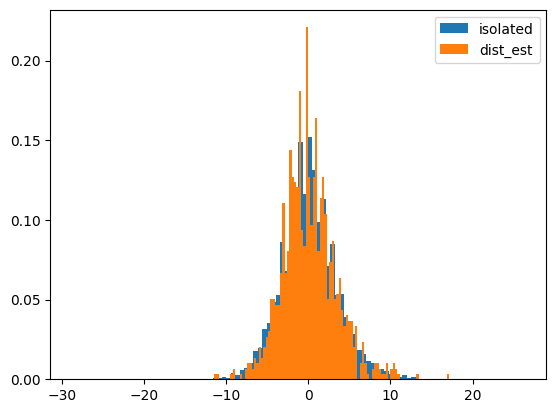

In [143]:
import matplotlib.pyplot as plt
plt.hist(for_isol_test_err_distribution["data"], bins=100, label="isolated", density=True)
plt.hist(for_dist_err_distribution["data"], bins=100, label="dist_est", density=True)
plt.legend()


In [144]:
#
for_isolated_test_err_distribution_gen_data = for_isol_test_err_distribution["kde"].resample(size=100000)
for_dist_err_distribution_gen_data = for_dist_err_distribution["kde"].resample(size=100000)
for_full_err_distribution_gen_data = full_test_err_distribution["kde"].resample(size=100000)



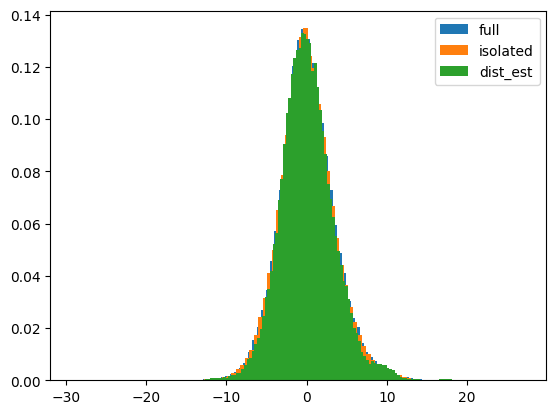

In [145]:
import matplotlib.pyplot as plt
plt.hist(for_full_err_distribution_gen_data[0], bins=100, label="full", density=True)
plt.hist(for_isolated_test_err_distribution_gen_data[0], bins=100, label="isolated", density=True)
plt.hist(for_dist_err_distribution_gen_data[0], bins=100, label="dist_est", density=True)
plt.legend()


In [44]:
np.mean(np.abs(for_isolated_test_err_distribution_gen_data[0]))

2.6394814713133905

In [45]:
np.mean(np.abs(for_dist_err_distribution_gen_data[0]))

2.6393775785771494

In [48]:
np.mean(np.abs(for_isolated_test_err_distribution['data']))

2.589721939012102